<center><h1>CS616: Human Centered Computing</h1></center>
<center><h2>Search Project</h2></center>

### Team Members
Aadvik Kumar (210002)  
Emaad Ahmed (210369)  
Rakesh Choudhary (210820)

<hr>
<br>

# 1. Preprocessing
## Importing Required Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup
import chardet
import unidecode

## Importing Browser History

In the following cells, we have imported the browser history and then changed it into the required format. 

In [ ]:
data = pd.read_csv('history_export_1.txt', sep="|", header = None)
data.columns = ["Time", "URL"]

In [ ]:
data['Time'] = pd.to_datetime(data['Time'])

In [ ]:
data.index = data['Time']
del data['Time']
domainList = [0]*len(data)

## Domain Information Extraction

* The code utilizes the requests library to retrieve content from a list of URLs.
* Custom headers, such as a User-Agent and email address, are integrated into the requests.
* The code employs the chardet library to automatically detect the character encoding of fetched web page content, enabling accurate content decoding, and it also employs encoding detection to decode content, offering a fallback to **UTF-8** with error handling for specific scenarios.
* **BeautifulSoup** is applied to parse the decoded content, concentrating on the title tag.
* Extracted titles are sanitized to eliminate Unicode characters, resulting in processed domain names.
* Exceptions arising during processing or parsing are managed, with affected entries receiving "Null" in the domain list.
* The code's core function involves deriving domain names from webpage titles and populating a list with the outcomes.

In [ ]:
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'Custom User Agent 1.0',
        'From': 'aadvik21@iitk.ac.in'  # Stick in your IITK email id
    }
)

In [ ]:
for idx in range(len(data)):
    print(idx)
    url = data.URL[idx]
    if len(url) > 5:
        try:
            r = requests.get(url, headers=headers)
            r.raise_for_status()  # Raise an exception for HTTP errors
        except requests.exceptions.RequestException as e:
            print(f"Error fetching URL {url}: {e}")
            continue  # Skip to the next URL if fetching failed

        try:
            # Detect the encoding of the response content
            encoding = chardet.detect(r.content)['encoding']

            try:
                decoded_text = r.content.decode(encoding)  # Try decoding using the detected encoding
            except UnicodeDecodeError:
                if encoding == 'Windows-1254':
                    decoded_text = r.content.decode('utf-8', errors='ignore')  # Decode using UTF-8 and ignore errors
                else:
                    print(f"Error decoding content for URL {url} using encoding {encoding}")
                    continue  # Skip to the next URL if decoding fails

            soup = BeautifulSoup(decoded_text, 'html.parser')
            if len(soup('title')) > 0:
                title_string = soup('title')[0].string
                if title_string is not None:
                    domain_name = unidecode.unidecode(title_string.strip())  # Convert Unicode characters
                    domainList[idx] = domain_name
                    print(domain_name)
                else:
                    domainList[idx] = "Null"
            else:
                domainList[idx] = "Null"
        except Exception as e:
            print(f"Error processing URL {url}: {e}")
            domainList[idx] = "Null"

In [ ]:
data['Domain'] = domainList
data.to_csv('fox2_history.csv')

In [73]:
data = pd.read_csv('fox2_history.csv')
cp_data = data
activity_df = data
data.Time = pd.to_datetime(data.Time)
docs = data.Domain.unique()

<hr>

# 2. Tokenization 

In [5]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<h2> Tokenization:</h2>
Utilizes the RegexpTokenizer from NLTK Library to split text into words based on a regular expression (r'\w+').
<h2> Stop Word Removal:</h2>
Imports the get_stop_words function to obtain a list of English stop words.
<h2> Stemming: </h2>
Imports the PorterStemmer class from NLTK to perform word stemming.

In [6]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()


In [7]:
doc_set = docs.tolist()

## Document Processing:
Each document is converted to lowercase and tokenized with the **RegexpTokenizer**. Removes stop words from the list of stop words obtained. The **PorterStemmer** is used for stemming. Adds the processed and tokenized document to the list of texts.

In [8]:
texts = []

# loop through document list
for i in doc_set:
    try:
        i.encode()
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
    
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
        # add tokens to list
        texts.append(stemmed_tokens)
    except AttributeError:
        texts.append([])
        pass
    except UnicodeDecodeError:
        texts.append([])
        pass

## Dictionary and Corpus Creation:
Using the texts list, creates a document-term dictionary (corpora.Dictionary).
doc2bow converts the tokenized documents into a document-term matrix (corpus) using the created dictionary.

In [9]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

<hr>
<h1>3. Topic Modelling</h1>

## LDA

This code generates an LDA (Latent Dirichlet Allocation) model using Gensim library for topic modeling. It trains the model on a given corpus with 3 topics, setting a minimum probability threshold for word inclusion and iterating 40 times for training. The resulting model will assign topics to documents based on the distribution of words within each topic.

In [47]:
# generate LDA model
min_prob_threshold = 0.1
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, minimum_probability=min_prob_threshold, id2word = dictionary, passes=40)

In [48]:
ldamodel.print_topics(3)

[(0,
  '0.088*"googl" + 0.078*"search" + 0.013*"github" + 0.011*"iitk" + 0.011*"kaggl" + 0.005*"drive" + 0.005*"interviewbit" + 0.005*"0" + 0.005*"firefox" + 0.005*"find"'),
 (1,
  '0.066*"youtub" + 0.019*"onlin" + 0.015*"s" + 0.014*"free" + 0.013*"watch" + 0.012*"famili" + 0.011*"short" + 0.010*"modern" + 0.007*"sub" + 0.007*"9anim"'),
 (2,
  '0.046*"youtub" + 0.011*"arduino" + 0.008*"c" + 0.008*"forum" + 0.006*"1" + 0.006*"comedi" + 0.006*"kanpur" + 0.006*"iit" + 0.006*"atmega328pb" + 0.005*"can"')]

In [49]:
ldamodel.get_topic_terms(0,10)

[(30, 0.0882673),
 (19, 0.07829654),
 (306, 0.012923355),
 (308, 0.01074297),
 (1541, 0.010672645),
 (304, 0.005475828),
 (173, 0.0054481844),
 (0, 0.005421352),
 (5, 0.0050921217),
 (344, 0.004769466)]

## WordCloud 
This code uses the wordcloud library to create and display word clouds for each topic in an LDA model. It iterates through topics, extracts the top 200 words' frequencies using show_topic, and generates word clouds from these frequencies with a specified font. Each word cloud visually represents the most prominent words in a topic's distribution. 

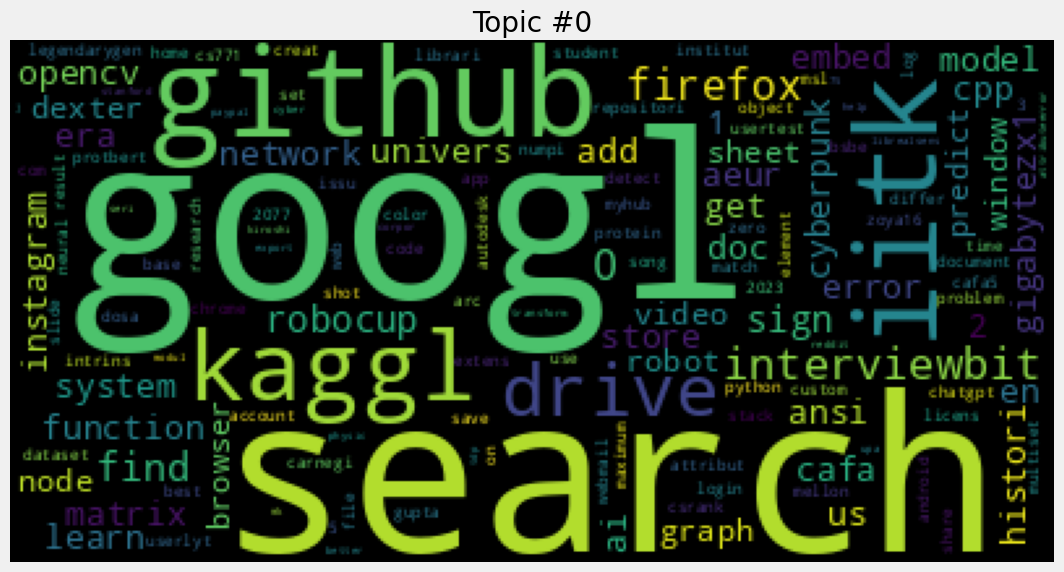

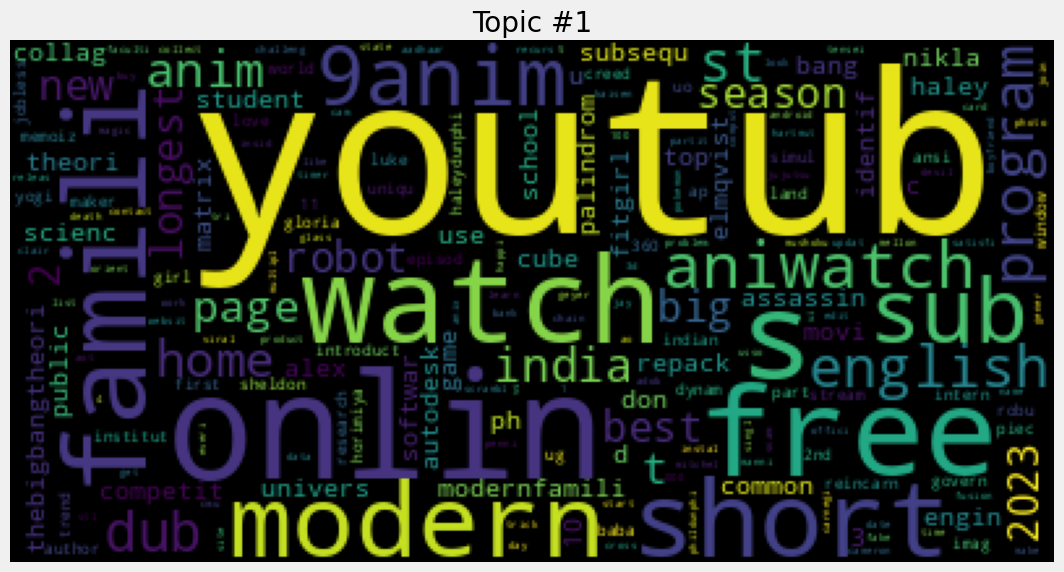

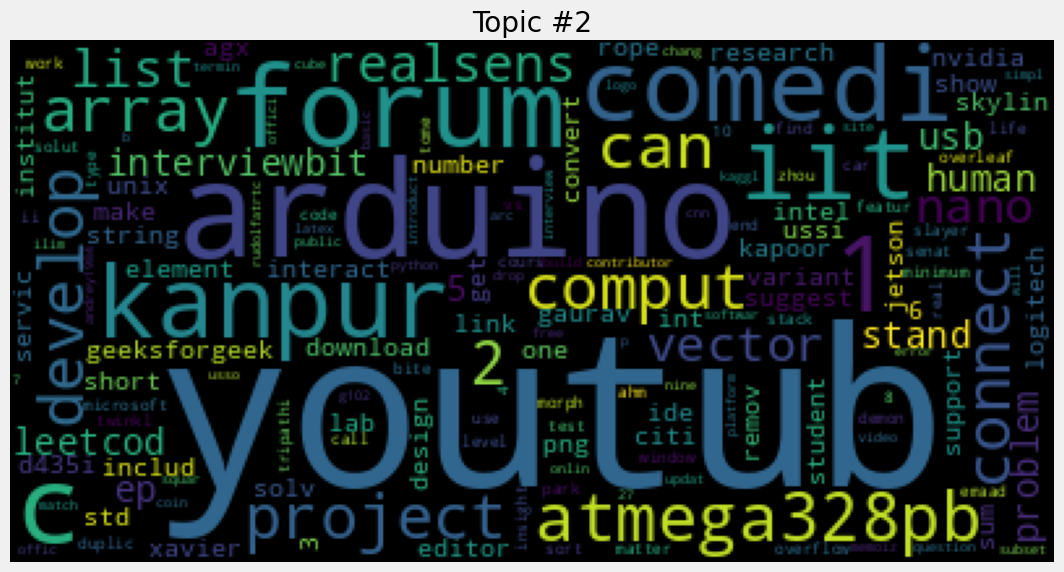

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming ldamodel.num_topics is defined somewhere

for t in range(ldamodel.num_topics):
    plt.figure(figsize=(12, 8))
    topic_words = dict(ldamodel.show_topic(t, 200))
    plt.imshow(WordCloud().generate_from_frequencies(topic_words))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


## Topic Mapping 
This code assigns topics to documents using an LDA model's probabilities. For each document in the input data, it calculates the topic probabilities using the model and the document's tokenized form. The code then identifies the topic with the highest probability and records its index in the topic list. This provides a way to map each document to its most probable topic based on the LDA model.

In [75]:
topic = [0]*len(data)
for idx in range(len(data)):
    test_idx = doc_set.index(data.Domain[idx])
    probs = ldamodel[dictionary.doc2bow(texts[test_idx])]
    prs = [item for sublist in probs for item in sublist]
    topicProbs = []
    for i in probs:
        topicProbs.append(i[1])
    topic[idx] = np.argmax(np.asarray(topicProbs))

In [76]:
data['Topic'] = topic

## Topic vs Time Graph

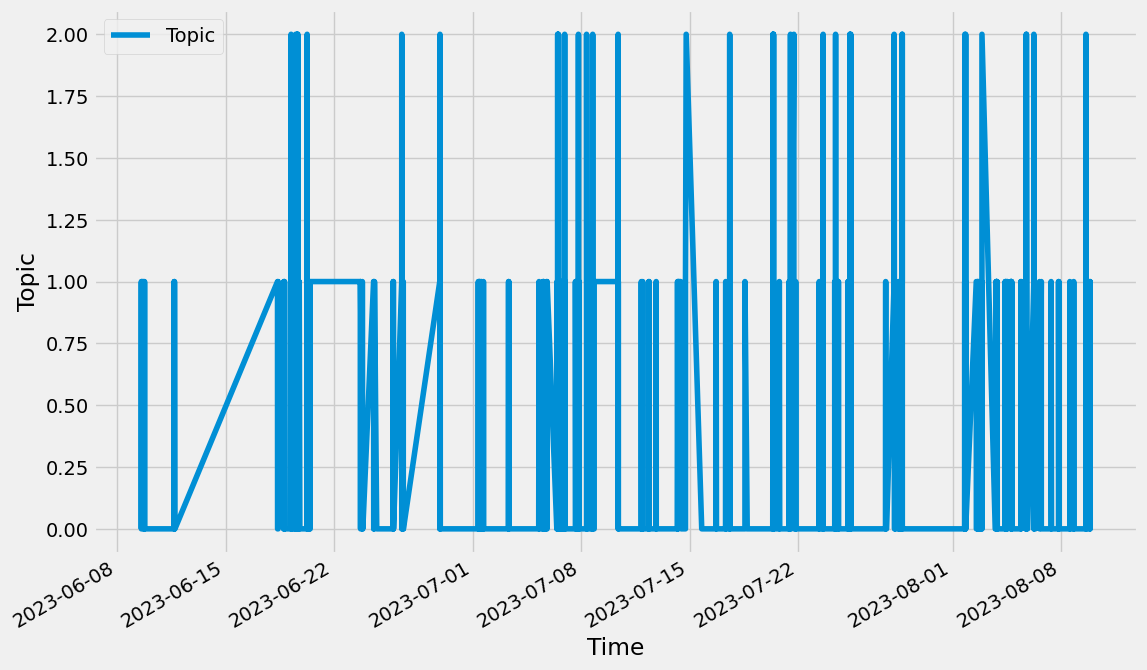

In [77]:
sorted_data = data.sort_values('Time')
plt.style.use('fivethirtyeight')
sorted_data.plot(x='Time', y='Topic', figsize=(12,8))
plt.ylabel('Topic')
plt.show()

In [ ]:
cp_data['Time'] = pd.to_datetime(cp_data['Time'])
cp_data.index = cp_data['Time']
del cp_data['Time']
cp_data.head()

## Day-wise Topic visits

We have calculated the occurrences of topics for each weekday and organized the data into separate lists for each topic

In [ ]:
occurrences = []
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for day in weekdays:
    tlist = cp_data[cp_data.index.day_name() == day]['Topic'].tolist()
    res = np.histogram(tlist,bins=[0,1,2,3])
    occurrences.append(list(res[0]))

In [ ]:
t0 = [0]*len(occurrences)
t1 = [0]*len(occurrences)
t2 = [0]*len(occurrences)

for d in range(len(occurrences)):
    t0[d] = occurrences[d][0]
    t1[d] = occurrences[d][1]
    t2[d] = occurrences[d][2]

cumt1 = [sum(x) for x in zip(t0, t1)]

In [ ]:
topic_labels = ['A','B','C']

### This graph shows the topic-wise web visits done for each day in the week

In [ ]:
plt.figure(figsize=(12,8))
p0 = plt.bar(range(7), t0, 0.4, label=topic_labels[0])
p1 = plt.bar(range(7), t1, 0.4,bottom=t0, color='green', label=topic_labels[1])
p2 = plt.bar(range(7), t2, 0.4, bottom=cumt1, color='red', label=topic_labels[2])
plt.xticks(range(7), weekdays, size='small')
plt.xlabel('Days of the week')
plt.ylabel('Web visits')
plt.legend()
plt.show()

## Time-wise Topic visits

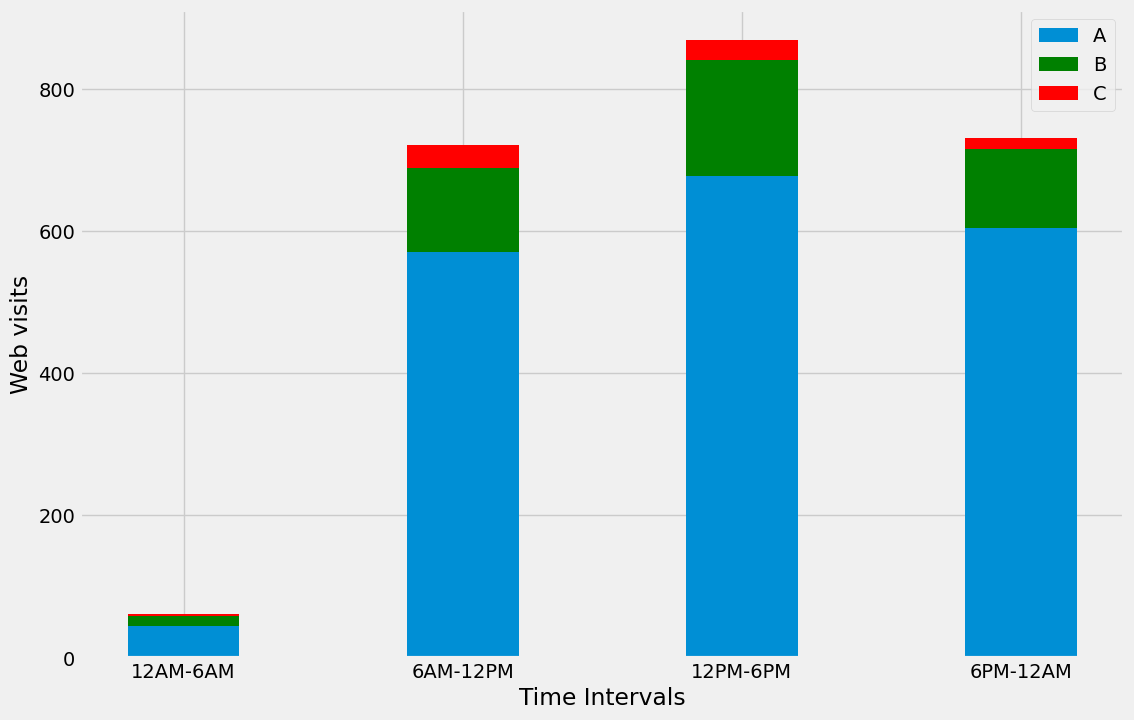

In [54]:
time_intervals = [
    (0, 6),   # 12:00 AM - 6:00 AM
    (6, 12),  # 6:00 AM - 12:00 PM
    (12, 18), # 12:00 PM - 6:00 PM
    (18, 24)  # 6:00 PM - 12:00 AM
]

occurrences = []

for start, end in time_intervals:
    tlist = cp_data[(cp_data.index.hour >= start) & (cp_data.index.hour < end)]['Topic'].tolist()
    
    res = np.histogram(tlist, bins=[0, 1, 2, 3])
    occurrences.append(list(res[0]))

t0 = [0] * len(occurrences)
t1 = [0] * len(occurrences)
t2 = [0] * len(occurrences)

for d in range(len(occurrences)):
    t0[d] = occurrences[d][0]
    t1[d] = occurrences[d][1]
    t2[d] = occurrences[d][2]

cumt1 = [sum(x) for x in zip(t0, t1)]
plt.figure(figsize=(12, 8))
p0 = plt.bar(range(len(time_intervals)), t0, 0.4, label=topic_labels[0])
p1 = plt.bar(range(len(time_intervals)), t1, 0.4, bottom=t0, color='green', label=topic_labels[1])
p2 = plt.bar(range(len(time_intervals)), t2, 0.4, bottom=cumt1, color='red', label=topic_labels[2])

time_labels = ['12AM-6AM', '6AM-12PM', '12PM-6PM', '6PM-12AM']
plt.xticks(range(len(time_intervals)), time_labels)
plt.xlabel('Time Intervals')
plt.ylabel('Web visits')
plt.legend()
plt.show()

## Topic-wise Web visits over the year

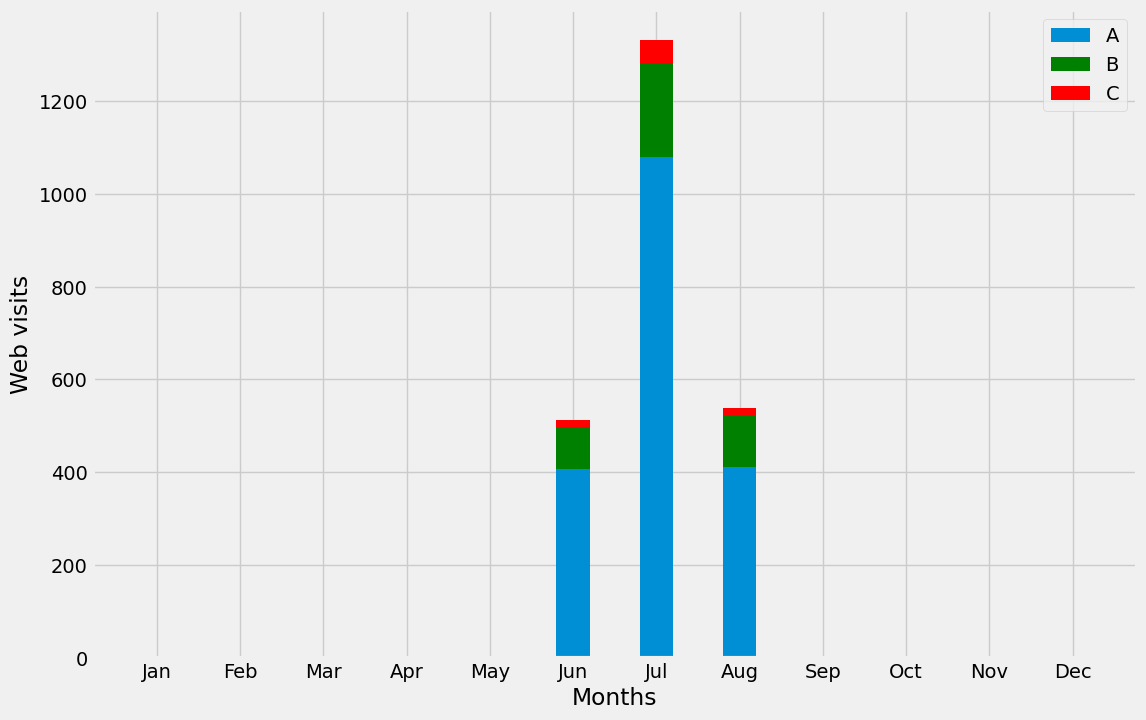

In [55]:
months = range(1, 13)  # Assuming data spans 12 months

occurrences = []

for month in months:
    tlist = cp_data[cp_data.index.month == month]['Topic'].tolist()
    
    res = np.histogram(tlist, bins=[0, 1, 2, 3])
    occurrences.append(list(res[0]))

t0 = [0] * len(occurrences)
t1 = [0] * len(occurrences)
t2 = [0] * len(occurrences)

for d in range(len(occurrences)):
    t0[d] = occurrences[d][0]
    t1[d] = occurrences[d][1]
    t2[d] = occurrences[d][2]

cumt1 = [sum(x) for x in zip(t0, t1)]
plt.figure(figsize=(12, 8))
p0 = plt.bar(range(len(months)), t0, 0.4, label=topic_labels[0])
p1 = plt.bar(range(len(months)), t1, 0.4, bottom=t0, color='green', label=topic_labels[1])
p2 = plt.bar(range(len(months)), t2, 0.4, bottom=cumt1, color='red', label=topic_labels[2])

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(len(months)), month_labels)
plt.xlabel('Months')
plt.ylabel('Web visits')
plt.legend()
plt.show()

<hr>

# 4. Transition Points 

In [56]:
activity_df = pd.read_csv('fox2_history.csv')
activity_df['Time'] = pd.to_datetime(activity_df['Time'])
activity_df = activity_df.sort_values(by='Time')


This code identifies transition points in activity_df based on time gaps exceeding a specified threshold (time_gap_threshold). These transition points indicate moments of significant time gaps between consecutive rows. The code iterates through the DataFrame, calculates time gaps, and records indices of transition points. The resulting transition points are then aligned with a given corpus. It is useful for detecting significant temporal shifts in the data and correlating them with a specified corpus.

In [57]:
time_gap_threshold = pd.Timedelta(minutes=10)  # Dwell time threshold
transition_points = []
prev_time = None


for idx, row in activity_df.iterrows():
    if prev_time is not None:
        time_gap = row['Time'] - prev_time
        if time_gap > time_gap_threshold:
            transition_points.append(idx - 1)  # Align the transition points with the corpus
    prev_time = row['Time']


transition_points = [point for point in transition_points if 0 <= point < len(corpus)]

print("Transition points aligned with corpus:", transition_points)

Transition points aligned with corpus: [1257, 1251, 1248, 1240, 1237, 1211, 1208, 1181, 1163, 1162, 1159, 1155, 1153, 1152, 1149, 1148, 1146, 1143, 1142, 1141, 1138, 1137, 1128, 1127, 1117, 1056, 1054, 1053, 1052, 1046, 1042, 1039, 1038, 932, 929, 928, 926, 922, 921, 912, 908, 901, 899, 896, 882, 878, 877, 876, 874, 873, 871, 860, 855, 832, 823, 821, 820, 815, 811, 806, 801, 796, 765, 759, 757, 756, 676, 667, 666, 665, 661, 660, 659, 658, 651, 650, 634, 633, 629, 627, 615, 610, 605, 585, 584, 566, 561, 537, 503, 493, 480, 474, 473, 472, 471, 470, 441, 431, 406, 387, 384, 379, 378, 377, 376, 368, 364, 363, 330, 319, 316, 314, 312, 299, 286, 277, 269, 268, 259, 246, 241, 228, 226, 224, 223, 216, 210, 209, 202, 200, 198, 197, 193, 192, 191, 189, 187, 182, 179, 177, 176, 175, 168, 152, 137, 136, 114, 113, 92, 89, 87, 82, 25, 24, 22, 21, 20, 11, 0]


<br>
<br>
The code below, utilizes the identified transition points to analyze topic distributions associated with specific activities. For each transition point within the valid range, the code retrieves the corresponding activity sequence from the corpus. It then uses the LDA model to determine the distribution of topics related to that activity sequence.

In [58]:
for point in transition_points:
    aligned_point = point 
    if 0 <= aligned_point < len(corpus):
        activity_sequence = corpus[aligned_point]  # Get the activity sequence at aligned point
        topic_distribution = ldamodel.get_document_topics(activity_sequence)  # Get topic distribution
        print(f"Transition at point {point}:")
        for topic, prob in topic_distribution:
            print(f"Topic {topic}: Probability {prob}")
        print("\n")
    else:
        print(f"Transition point {point} is out of range.")

Transition at point 1257:
Topic 0: Probability 0.77684485912323
Topic 1: Probability 0.11154346168041229
Topic 2: Probability 0.1116117462515831


Transition at point 1251:
Topic 0: Probability 0.39775601029396057
Topic 2: Probability 0.5525760054588318


Transition at point 1248:
Topic 0: Probability 0.3439183533191681
Topic 2: Probability 0.6129291653633118


Transition at point 1240:
Topic 0: Probability 0.8856617212295532


Transition at point 1237:
Topic 0: Probability 0.6389320492744446
Topic 1: Probability 0.29390162229537964


Transition at point 1211:
Topic 0: Probability 0.48977717757225037
Topic 2: Probability 0.45857831835746765


Transition at point 1208:
Topic 0: Probability 0.8298766613006592


Transition at point 1181:
Topic 1: Probability 0.9291685223579407


Transition at point 1163:
Topic 0: Probability 0.8285531997680664


Transition at point 1162:
Topic 1: Probability 0.14991691708564758
Topic 2: Probability 0.8218144774436951


Transition at point 1159:
Topic 0: P

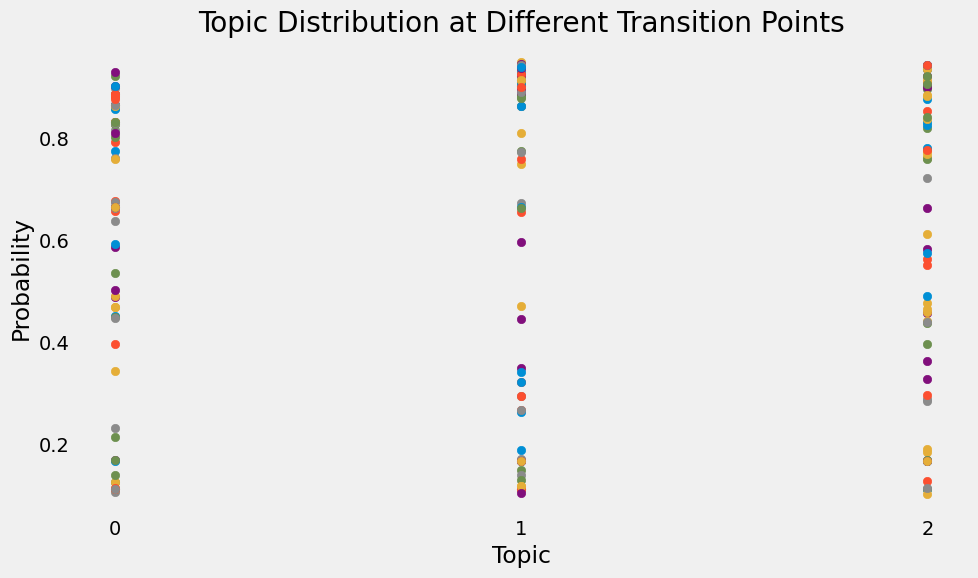

In [59]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Loop through the aligned transition points and plot topic distributions as scatter plots
for point in transition_points:
    aligned_point = point 
    if 0 <= aligned_point < len(corpus):
        activity_sequence = corpus[aligned_point]  # Get the activity sequence at aligned point
        topic_distribution = ldamodel.get_document_topics(activity_sequence)  # Get topic distribution
        
        # Extract topic indices and probabilities
        topics = np.array([topic for topic, _ in topic_distribution])
        probs = np.array([prob for _, prob in topic_distribution])
        
        # Plot topic distribution as a scatter plot
        ax.scatter(topics, probs, label=f"Transition Point {point}")

ax.set_xlabel('Topic')
ax.set_ylabel('Probability')
ax.set_title('Topic Distribution at Different Transition Points')
ax.set_xticks(topics)
# ax.legend()
ax.grid()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from hmmlearn import hmm
from hmmlearn.hmm import MultinomialHMM

The code processes the transition points by collecting topic distribution probabilities associated with each activity sequence. For each transition point within the valid range, the code retrieves the activity sequence from the corpus. It then calculates and collects the topic probabilities using the LDA model for that activity sequence.

In [61]:
learned_tp_characteristics = []
topic_probs_data = []
for point in transition_points:
    aligned_point = point 
    if 0 <= aligned_point < len(corpus):
        activity_sequence = corpus[aligned_point]
        topic_distribution = ldamodel.get_document_topics(activity_sequence)
        topic_probs = [prob for _, prob in topic_distribution]
        topic_probs_data.append(topic_probs)

In [62]:
activity_df['Time'] = pd.to_datetime(activity_df['Time'])  # Convert 'Time' column to datetime if not already
activity_df['TimeGap'] = activity_df['Time'].diff().fillna(pd.Timedelta(0))
activity_df['TimeGapInSeconds'] = activity_df['TimeGap'].dt.total_seconds()


The code processes topic probability data and temporal characteristics for further analysis. It first aligns and pads the topic probability data to ensure consistent dimensions across sequences. The temporal characteristics, represented as time gaps, are retrieved and normalized using the **StandardScaler**. The normalized time gaps are then combined with the padded topic probability data to create a feature matrix named concatenated_features. This matrix integrates both **temporal** and **topic probability information.**

In [63]:
max_num_topics = max(len(sublist) for sublist in topic_probs_data)
padded_topic_probs = [sublist + [0.0] * (max_num_topics - len(sublist)) for sublist in topic_probs_data]
topic_probs_array = np.array(padded_topic_probs)
temporal_characteristics = activity_df.loc[transition_points, 'TimeGapInSeconds'].values.reshape(-1, 1)

scaler = StandardScaler()
normalized_temporal_characteristics = scaler.fit_transform(temporal_characteristics)
concatenated_features = np.hstack((normalized_temporal_characteristics, topic_probs_array))

For our personalised recommender system, we made a train-test split of approximately **0.9**

In [64]:
test_size = 140
train_points = transition_points[:test_size] 
train_features = concatenated_features[:test_size]

The code uses the hmm.GaussianHMM class from the hmmlearn library to train a Hidden Markov Model (HMM) on the concatenated feature matrix concatenated_features.

The code trains a **Hidden Markov Model (HMM)** using the hmmlearn library to capture underlying patterns in the data. The model is built with a specified number of hidden states (num_states). By fitting the model to a concatenated feature matrix containing both **normalized temporal characteristics** and **topic probabilities**, the HMM learns transition probabilities between states. These transition probabilities represent the dynamics of state transitions in the data. The trained HMM can subsequently be employed to analyze how topics and temporal characteristics evolve over time and reveal insights into the underlying patterns of the dataset.
Notably, the code also employs GridSearchCV to systematically explore various hyperparameters, such as the number of hidden states and covariance type, optimizing the HMM's performance.

In [67]:

param_grid = {
    'n_components': [3],  # Number of hidden states
    'covariance_type': ['diag', 'full'],  # Type of covariance matrix
    'n_iter': [100, 200, 300],  # Number of iterations
}

# Create a GaussianHMM model instance
hmm_model = hmm.GaussianHMM()

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=hmm_model, param_grid=param_grid)
grid_search.fit(train_features)  # Fit the GridSearchCV object to the training data

# Get the best parameters found by the grid search
best_params = grid_search.best_params_

# Access the transition probabilities from the best fitted model
best_model = grid_search.best_estimator_
transition_probabilities = best_model.transmat_
print(transition_probabilities)
print(best_params)

Model is not converging.  Current: 676.8767015725274 is not greater than 676.877971037554. Delta is -0.0012694650265530072
Model is not converging.  Current: 756.4233902761206 is not greater than 1789.4643582968386. Delta is -1033.040968020718
Model is not converging.  Current: 758.5160561115647 is not greater than 825.4178261709922. Delta is -66.90177005942746
Model is not converging.  Current: 844.5215980180288 is not greater than 1512.1612034628076. Delta is -667.6396054447788
Model is not converging.  Current: 1016.0431163932572 is not greater than 1917.1071750370616. Delta is -901.0640586438044


[[3.56914159e-01 3.94081383e-02 6.03677703e-01]
 [9.97919868e-01 1.98029679e-03 9.98349360e-05]
 [2.83270383e-01 3.13654788e-02 6.85364139e-01]]
{'covariance_type': 'full', 'n_components': 3, 'n_iter': 100}


<br>

This **heatmap** depicts transition probabilities learned from the above Hidden Markov Model (HMM).

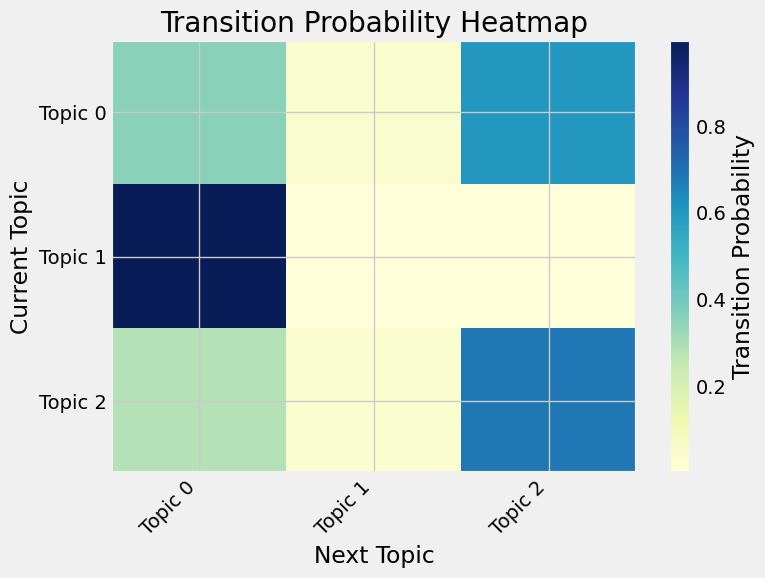

In [68]:
state_labels = ['Topic 0', 'Topic 1', 'Topic 2']

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(transition_probabilities, cmap='YlGnBu', interpolation='nearest', aspect='auto')

# Set labels for rows and columns
plt.xticks(np.arange(len(state_labels)), state_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(state_labels)), state_labels)
plt.xlabel('Next Topic')
plt.ylabel('Current Topic')

# Display the color bar
cbar = plt.colorbar()
cbar.set_label('Transition Probability')

# Set title and show the plot
plt.title('Transition Probability Heatmap')
plt.tight_layout()
plt.show()

<hr>

# 5. Recommender System 

We have generated recommendations for next topics using learned transition probabilities from the HMM. For each transition point, we have identified the current topic by selecting the topic with the highest probability in the topic distribution obtained from the LDA model. Then, retrieved the corresponding row of transition probabilities for the current topic.  
<br>
The code computes and prints the probabilities of transitioning to different topics based on the transition model. Additionally, it suggests the recommended next topic by choosing the one with the highest probability from the transition probabilities for the current topic. This process provides valuable insights into the potential topic shifts and offers recommendations for the next topic at each transition point within the dataset.

In [70]:
recommendations_data = []

for point in transition_points[140:]:
    aligned_point = point
    if 0 <= aligned_point < len(corpus):
        activity_sequence = corpus[aligned_point]
        topic_distribution = ldamodel.get_document_topics(activity_sequence)
        current_topic = max(topic_distribution, key=lambda x: x[1])[0]
        recommended_next_topic_probs = transition_probabilities[current_topic]
        recommended_next_topic = np.argmax(recommended_next_topic_probs)
        
        recommendation_info = {
            'TransitionPoint': point,
            'CurrentTopic': current_topic,
            'RecommendedTopic': recommended_next_topic
        }
        
        recommendations_data.append(recommendation_info)
            
recommendations_df = pd.DataFrame(recommendations_data)

recommendations_df.to_csv('recommendations.csv', index=False)

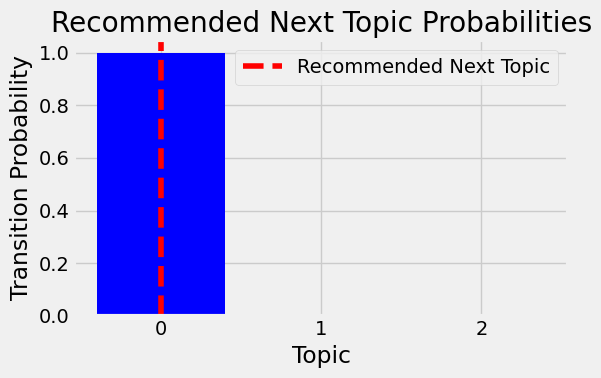

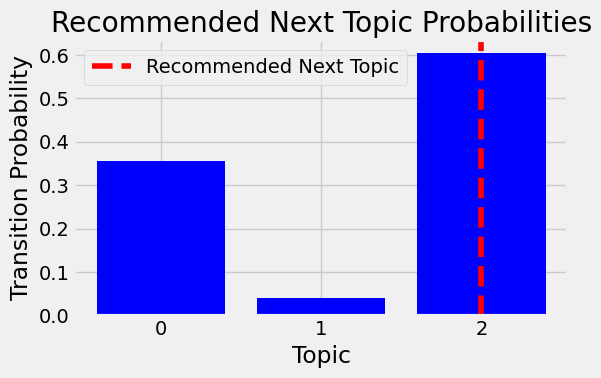

In [71]:
import matplotlib.pyplot as plt

for point in transition_points:
    aligned_point = point 
    if 0 <= aligned_point < 20:
        activity_sequence = corpus[aligned_point] 
        topic_distribution = ldamodel.get_document_topics(activity_sequence) 
        current_topic = max(topic_distribution, key=lambda x: x[1])[0]
        recommended_next_topic_probs = transition_probabilities[current_topic]
        recommended_next_topic = np.argmax(recommended_next_topic_probs)
        
        plt.figure(figsize=(6, 4))
        plt.bar(range(len(recommended_next_topic_probs)), recommended_next_topic_probs, color='blue')
        plt.xlabel('Topic')
        plt.ylabel('Transition Probability')
        plt.title('Recommended Next Topic Probabilities')
        plt.xticks(range(len(recommended_next_topic_probs)), range(len(recommended_next_topic_probs)))
        plt.axvline(x=recommended_next_topic, color='red', linestyle='--', label='Recommended Next Topic')
        plt.legend()
        plt.tight_layout()
        plt.show()